In [170]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import os
import math

from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
import scipy.stats as stats

#from mpltools import special ##leon

plt.style.use('seaborn-poster')

# DEFINE DATA CLASS
class RawData(object):
    def __init__(self,timestamp,keytime,ttime,keypress,targetid,target_lon,target_lat,target_x,target_y,target_z,hmd_rx,hmd_ry,hmd_rz):
        self.timestamp=timestamp # 1 (default time?)
        self.keytime=keytime # 2 +Time.deltaTime
        self.ttime=ttime # 3 Time.time
        self.keypress=keypress # 4
        self.targetid=targetid # 5
        self.target_lon=target_lon
        self.target_lat=target_lat
        self.target_x=target_x
        self.target_y=target_y
        self.target_z=target_z
        self.hmd_rx=hmd_rx # 11
        self.hmd_ry=hmd_ry # 12
        self.hmd_rz=hmd_rz # 13

class TimeData(object):
    def __init__(self,targetid,target_lon,target_lat,deltatime):
        self.targetid=targetid
        self.target_lon=target_lon
        self.target_lat=target_lat
        self.deltatime=deltatime


class Target(object):
    def __init__(self, lat, lon, user, test):
        self.targetid=targetid
        self.target_lon=target_lon
        self.target_lat=target_lat
        self.deltatime=deltatime
        
    def add_user(flie):
        


## READ DATA
def read_data(file):
    raw_data=[]
    print("Reading %s"%file)
    seperator="\t"
    with open(file,"r") as fp:
        for line in fp:
            if line.startswith("Time"):
                continue     ## Skip the Header
            l=line[:-1]   ## Delete the Last Element then Return
            f=l.split(seperator)   ## Divide the Raw Data to Pieces
            if(int(f[3])==1):   ## 4.When Finish Targeting and Press Key
                raw_data.append(RawData(f[0],float(f[1]),float(f[2]),float(f[3]),float(f[4]),float(f[5]),float(f[6]),float(f[7]),float(f[8]),float(f[9]),float(f[10]),float(f[11]),float(f[12])))
            else: 
                raw_data.append(RawData(f[0],float(f[1]),float(f[2]),float(f[3]),float(f[4]),0,0,0,0,0,float(f[10]),float(f[11]),float(f[12])))
                
    return raw_data



# Input Raw Data, Each Tester, return aim_time[[[,,,],,,,,][,,,,,][,,,,,]] 3-layer array
# Every Target Aiming Time in aim_time[lat][lon] = [first, second, third]
def aim_time_filter(input_raw_data):
    aim_time={}
    filtered_data=[a for a in input_raw_data if a.keypress==1]

    for i in range(len(filtered_data)-1):
        if(filtered_data[i+1].targetid!=filtered_data[i].targetid):
            continue # when resuming back
        if((i <= len(filtered_data)-3) and (filtered_data[i-1].targetid==filtered_data[i+2].targetid)):
            continue # when two same targets appear one after one
        delta_time=filtered_data[i+1].ttime-filtered_data[i].ttime
        #print(delta_time, filtered_data[i].targetid)

        key1=str(int(filtered_data[i].target_lat))
        key2=str(int(filtered_data[i].target_lon))
        if(key1 in aim_time)==False:
            aim_time[key1]={}
        if(key2 in aim_time[key1])==False:
            aim_time[key1][key2]=[]
        
        aim_time[key1][key2].append(TimeData(filtered_data[i].targetid,filtered_data[i].target_lon,filtered_data[i].target_lat,delta_time))
    
    aim_time[str(0)][str(0)]=[]   # Special (0,0) Not Exist but for data processing, add a pseudo datum
    aim_time[str(0)][str(0)].append(TimeData(float(21),float(0),float(0),float(0)))

    return aim_time   # aim_time is 3*3*7 array{}

LAT_KEY = ('-30','0','30')
LON_KEY = ['0','30','60','90','120','150','180']

def extract_time(input_time):
    #lat = [a for a in input_time]
    #lon = [b for b in input_time[lat]]
    #target = [c.deltatime for c in input_time[lon] ]
    
    time_dict = {}
    #time_flat = [] # not useful, not sorted
    
    lat_order = ['-30','0','30']
    lon_order = ['0','30','60','90','120','150','180']
    
    for lat in lat_order:
        time_dict[lat] ={}
        #time_lon = []
        for lon in lon_order:
            time_dict[lat][lon] = [target.deltatime for target in input_time[lat][lon]]
            #time_target = [target.deltatime for target in input_time[lat][lon]]
            #time_lon.append(time_target)
        #time_flat.append(time_lon)

    return time_dict#, time_flat

def flatten_data(input_data):
    
    flat_data = []
    
    for lat in input_data:
        data_lon = []
        for lon in input_data[lat]:
            data_target = [target for target in input_data[lat][lon]]
            data_lon.append(data_target)
        flat_data.append(data_lon)
    
    return flat_data

# NOT IN USE
def sort_data(input_data):
    
    sorted_data = []
    
    lat_order = ['-30','0','30']
    lon_order = ['0','30','60','90','120','150','180']
    
    for lat in lat_order:
        data_lon = []
        for lon in lon_order:
            data_target = [target for target in input_data[lat][lon]]
            data_lon.append(data_target)
        sorted_data.append(data_lon)
        
    return sorted_data
    
    
def extract_time_speed(input_time):
    time_dict = {}
    speed_dict = {}
    time_flat = []
    speed_flat = []

    key1=[-30, 0, 30]
    key2=[0,30,60,90,120,150,180]
    k1=[str(a) for a in key1]
    k2=[str(a) for a in key2]

    for i in range(len(input_time)):
        time_dict[k1[i]] = {}
        speed_dict[k1[i]] = {}
        time_flat[k1[i]] = []
        speed_flat[k1[i]] = []

        for j in range(len(input_time[i])):
            time_dict[k1[i]][k2[i]] = {}
            speed_dict[k1[i]][k2[i]] = {}
            time_flat[k1[i]][k2[i]] = []
            speed_flat[k1[i]][k2[i]] = []

            for k in range(len(input_time[str(key1[i])][str(key2[j])])):
                if(input_time[str(key1[i])][str(key2[j])][k]==0):
                    #r.append(0) # speed = 0
                    speed[str(key1)][str(key2)].append(0)
                    continue

                angle = math.sqrt( (30*i-30)*(30*i-30) + (30*j)*(30*j) ) # for 1,2 approximately
                speed[str(key1)][str(key2)].append( angle / input_time[str(key1[i])][str(key2[j])][k] )

    return speed   
    

def time_to_speed(input_time):
    
    speed={}
    
    for lat in input_time:
        speed[lat]={}
        for lon in input_time[lat]:
            speed[lat][lon]=[]
            for target in range(len(input_time[lat][lon])):
                if (input_time[lat][lon][target]==0):
                    #r.append(0) # speed = 0
                    speed[lat][lon].append(0)
                    continue
                
                angle = angle_ac(int(lat), int(lon))
                speed[lat][lon].append( angle / input_time[lat][lon][target] )

    return speed    # 3*3*7 array{}

def angle_ap(lat, lon):
    angle = math.sqrt( lat**2 + lon**2 )
    return angle

def angle_ac(lat, lon):
    angle = math.degrees( math.acos( math.cos(math.radians(lat)) * math.cos(math.radians(lon)) ) )
    return angle


# NOT IN USE
def time_stat(path,raw,fig): # return
    raw_data=[]
    raw_data=read_data(path,raw_data)
    aim_time=aim_time_filter(raw_data)
    

    key1=['-30','0','30']    # 3 lat
    if (len(aim_time) == 1):
        key1=['0']    # 1 lat
    key2=[0,30,60,90,120,150,180]
    

    target_mean_s=[]
    target_std_s=[]
    for k1 in range(len(key1)):
        m1=[]
        s1=[]
        for k2 in range(len(key2)):
            if(k1==1 and k2==0):
            #if(k2==0):
                m1.append(0)
                s1.append(0)
                continue
            data=[a.delta_time for a in aim_time[key1[k1]][str(key2[k2])]]
            
            m1.append(np.mean(data))
            s1.append(np.std(data))
   
        target_mean_s.append(m1)
        target_std_s.append(s1)

    return target_mean_s, target_std_s    # 3*7 array[]


# Calculate the Mean and STD
def dict_stat(input_dict): # return

    key1=['-30','0','30']    # 3 lat
    if (len(input_dict) == 1):
        key1=['0']    # 1 lat
    key2=[0,30,60,90,120,150,180]
    
    #key3= [lat for lat in input_dict]
    #key4= [lon for lon in input_dict[key3[0]]]
    key3 = input_dict.keys()
    key4 = input_dict['0'].keys()
   
    if (tuple(input_dict.keys()) != LAT_KEY):
        print('Error may happen')
    
    target_mean={}
    target_std={}
    for lat in input_dict:
        target_mean[lat]={}
        target_std[lat]={}
        for lon in input_dict[lat]:
            if(input_dict[lat][lon]==[0]):
            #if(k2==0):
                target_mean[lat][lon]=0
                target_std[lat][lon]=0
                continue
            
            target_mean[lat][lon]=np.mean(input_dict[lat][lon])
            target_std[lat][lon]=np.std(input_dict[lat][lon])

    return target_mean, target_std    # 3*7 array[]

def list_stat(input_data): # return
    
    print(np.array(input_data).shape)
          
    target_mean=[]
    target_std=[]
    
    #for lon in range(len(input_data)):
    for lat in range(3):
        mean=[]
        std=[]
        #for lat in range(len(input_data[lon])):
        for lon in range(7):
            #if(lon==1 and lat==0):
            #if(k2==0):
            if (input_data[lat][lon] == [0]):
                mean.append(0)
                std.append(0)
                continue
            data = [target for target in input_data[lat][lon]]
            
            mean.append(np.mean(data))
            std.append(np.std(data))
   
        target_mean.append(mean)
        target_std.append(std)

    return target_mean, target_std    # 3*7 array[]



def cal_ratio(before, after):
    
    ratio=[]
    log=[]
    
    for i in range(len(before)):
        r=[]
        l=[]
        print(len(before[i]))
        for j in range(len(before[i])):
            if(mean_after[i][j]==0):
                #r.append(1) #ratio
                #l.append(0) #log
                continue
            r.append( after[i][j] / before[i][j] ) #ratio
            l.append(math.log2( after[i][j] / before[i][j] )) #log
            #print(i,j,mean_after[i][j],mean_before[i][j])
        ratio.append(r)
        log.append(l)
        
    print(np.array(ratio).shape)
    print(np.array(log).shape)
    return ratio,log



Reading ../Users/1/1.txt
(3, 7)
-- -30 --
0 : 1.1655999999999835
30 : 1.4431249999999807
60 : 1.8408999999999907
90 : 1.7947999999999809
120 : 2.420524999999998
150 : 3.0014750000000134
180 : 3.3586250000000035
-- 0 --
0 : 0
30 : 0.8902250000000151
60 : 2.065799999999996
90 : 1.388999999999972
120 : 1.7753749999999826
150 : 2.5881499999999846
180 : 3.0831750000000255
-- 30 --
0 : 1.2578250000000395
30 : 1.264360000000022
60 : 2.0546999999999827
90 : 1.9775999999999954
120 : 2.252625000000009
150 : 2.9802749999999776
180 : 4.94212499999999
-- 0 --
0 : 1.1655999999999835
1 : 1.4431249999999807
2 : 1.8408999999999907
3 : 1.7947999999999809
4 : 2.420524999999998
5 : 3.0014750000000134
6 : 3.3586250000000035
-- 1 --
0 : 0
1 : 0.8902250000000151
2 : 2.065799999999996
3 : 1.388999999999972
4 : 1.7753749999999826
5 : 2.5881499999999846
6 : 3.0831750000000255
-- 2 --
0 : 1.2578250000000395
1 : 1.264360000000022
2 : 2.0546999999999827
3 : 1.9775999999999954
4 : 2.252625000000009
5 : 2.9802749999

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

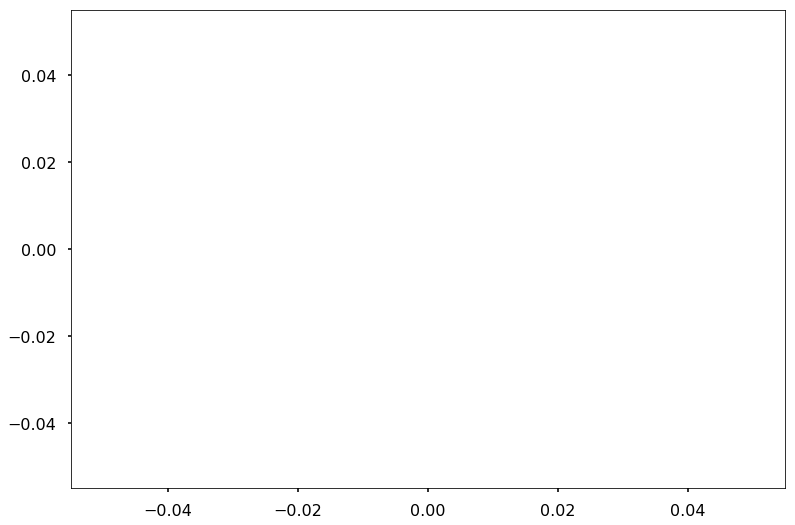

In [179]:

###################### choose user
users=[1,2,3,4,5,9,10,14,6,12,13,8,11,7]#after 13
#users=[14,16,17,18,19,15]
######################


for uid in range(len(users)):
    baseFolder=str(users[uid])
    #idx=[3,4,5]
    idx=[1,2]

baseFolder = "1"
raw_data = read_data("../Users/"+baseFolder+"/"+str(idx[0])+".txt")
aim_time = aim_time_filter(raw_data)
time_dict = extract_time(aim_time)

time_flat = flatten_data(time_dict)

speed_dict = time_to_speed_ap(time_dict)
speed_test = time_to_speed(time_dict)
sorted_speed = flatten_data(speed_dict)

mean,std = dict_stat(time_dict)
mean1,std1= list_stat(time_flat)

dict_to_print = mean
list_to_print = mean1



for x in range(3):
        print ('--', x, '--')
        for y in range(7):
            print (y,':',list_to_print[x][y])
mean_arr = np.array(time_flat)

print(mean_arr)
print(time_dict.keys())

plt.plot()
plt.fill_between(range(7), mean_arr[0],alpha=0.2, label="30")
if(False):
    for x in speed_dict:
        print ('--', x, '--')
        for y in speed_dict[x]:
            print (y,':', speed_dict[x][y])
    
    for x in speed_test:
        print ('--', x, '--')
        for y in speed_test[x]:
            print (y,':', speed_test[x][y])

    

    print(np.array(sorted_speed).shape)

    print(angle_ap(30,60), angle_ac(30,60))
    

